Necessary Imports

In [1]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

import os
from google.colab import drive

Download The Dataset & Define The Transforms

In [2]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training and testing data (batch_size=64)
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

Exploring The Data

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


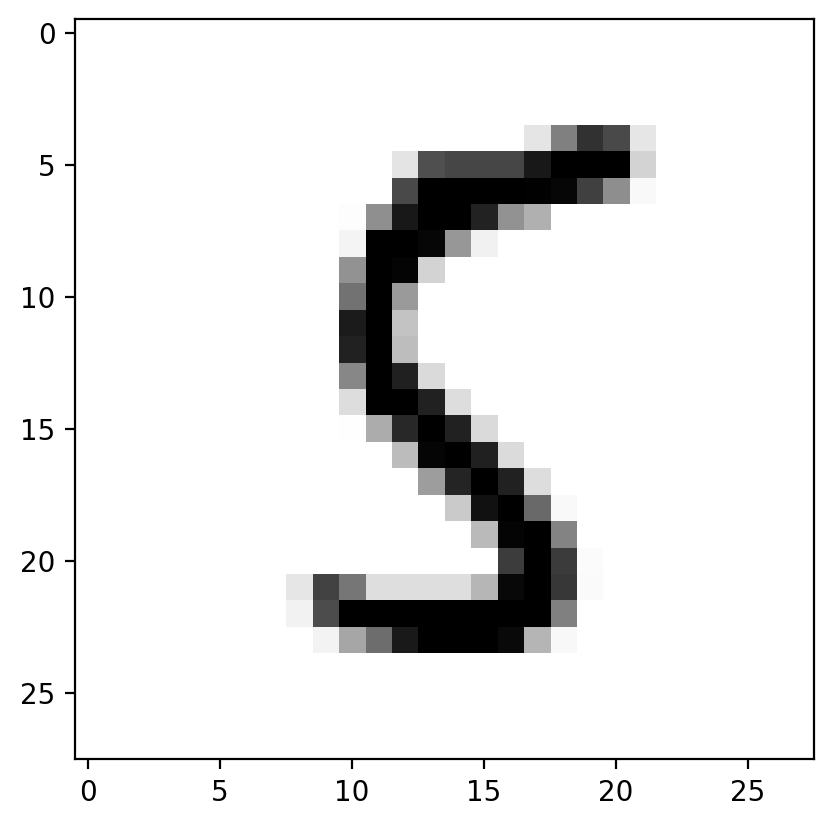

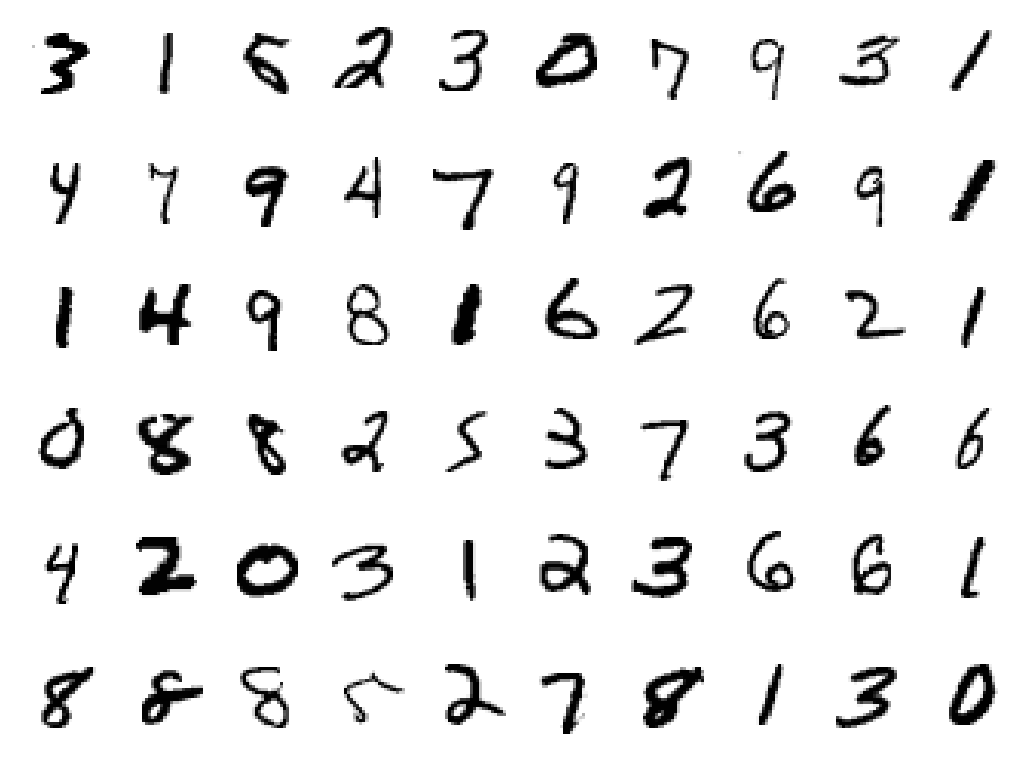

In [3]:
# To have a better understanding of out data,
# we visualize one of the images to better see how they look like

dataiter = iter(trainloader)
images, labels = next(dataiter)
# To get the shape of the image
print(type(images))
print(images.shape)
print(labels.shape)

# Plotting the first image
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

# Plotting some more images to have an idea of the set's pattern
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Defining The Neural Network

In [4]:
# Building the Neural Network with 4 layers:
# Input layer 28x28 = 784 neurons for 784 pixels of an image
# 1st hidden layer: 128 neurons
# 2nd hidden layer: 64 neurons
# Output layer: 10 neurons for 10 possible options (0-9)
# ReLU activation is used for hidden layers
# LogSoftmax for output layer because we are dealing with probabilities

from torch import nn

# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build the feed-forward network, with above mentioned specifications
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),  #positive values pass through, negative values modified as zero
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1)) #LogSoftmax activation rescale the 1-dim Tensor to have values between 0-1 and sum=1
print(model)

#Checking Cuda availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)


# Usage of Negative log-likelihood loss to clasify the result of the output
# and as the metric to observe during during training
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

# Loading images and their labels to GPU environment
logps = model(images.cuda())
loss = criterion(logps, labels.cuda())

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
cuda


Core Training Of Neural Network

In [5]:
### The whole optimization process (Core Training Process)
from torch import optim

# Stochastic Gradient Descent is used to optimize the model with:
# learning rate = 0.003
# moment = 0.9
# Model is set to be train for 60 epochs,
# with an early stop of 0.5 in change in the training loss
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 60
prev_loss = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad()

        output = model(images.cuda())
        loss = criterion(output, labels.cuda())

        #This is where the model learns by backpropagating
        loss.backward()

        # And optimizes its weights here
        optimizer.step()

        running_loss += loss.item()

    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss))

        # Check for early stop...
        if abs(running_loss-prev_loss) < 0.5:
          print('\nThere is no significant imporovement in the training process.\n\
Stop the training process to avoid overfitting!')
          break
        else:
          prev_loss = running_loss


        # Activate the below line to get info about the weights
        #print('Updated weights - ', model[0].weight)
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 600.8067500591278
Epoch 1 - Training loss: 263.1996500864625
Epoch 2 - Training loss: 205.0239766612649
Epoch 3 - Training loss: 165.33467059582472
Epoch 4 - Training loss: 139.24155296757817
Epoch 5 - Training loss: 120.53432759735733
Epoch 6 - Training loss: 105.11774554196745
Epoch 7 - Training loss: 93.76181066315621
Epoch 8 - Training loss: 85.36674441117793
Epoch 9 - Training loss: 76.4607093273662
Epoch 10 - Training loss: 70.34444976318628
Epoch 11 - Training loss: 64.76432408951223
Epoch 12 - Training loss: 58.428984958678484
Epoch 13 - Training loss: 54.65965779405087
Epoch 14 - Training loss: 49.44698490551673
Epoch 15 - Training loss: 45.57637190259993
Epoch 16 - Training loss: 42.75382947153412
Epoch 17 - Training loss: 40.29570145928301
Epoch 18 - Training loss: 36.05669154599309
Epoch 19 - Training loss: 34.381881610373966
Epoch 20 - Training loss: 31.789263932965696
Epoch 21 - Training loss: 30.068265086389147
Epoch 22 - Training loss: 27.645629

Model Evaluation

In [6]:
## Testing for the trained model

correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img.cuda())

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    # Convert from Tensor to a list of 10 numbers (0-9)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9768
